# **Chap8：图神经网络GNN**

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from source.code import ch8
from source.code import utils 
import os
import time

2023-07-14 09:28:32.850813: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-14 09:28:32.999174: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-14 09:28:33.030165: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-14 09:28:33.714702: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
# 如果你要在服务器上和别人共用GPU，可以设置你需要的显存资源
utils.gpu_limitation_config(memory=30,device=2)

## **8.2 理解图算子**

### **8.2.1 图Laplace算子：图上的卷积**

GNN 需要像其他神经网络家族成员一样，能够**自然地在图结构数据上进行计算、然后提取特征**，获得每个节点、全图的**特征表示**，最后用于下游任务，回顾一下主流的图任务有：
* 节点分类
* 图分类
* 无监督的节点聚类
* 边预测



而 GNN 在处理图数据时，会有之前的神经网络没有遇到过的问题：
* **缺乏一致的输入结构**：无论是表格数据、图片数据、还是文本数据，**它们都具有一致的输入结构**，相比而言，Graph 的输入结构灵活多变
  * 表格特征的输入都是一个矩阵 $X\in\mathbb{R}^{n\times p}$
  * 图像数据的输入特征都是 $X\in\mathbb{R}^{h\times w\times c}$ 的多通道高宽像素，即使每张图像的高宽不同，我们可以通过插值方法将其转换为相同高宽的图像
  * 文本数据的输入特征都是序列 $X=[x_1\cdots,x_T]$
  * 而对于图结构数据，可能面临
    * 图上的节点数量各不相同
    * 节点的类型可能不同（异构图）
    * 每个节点的连接的邻居个数不同
    * 图上的连接关系可能不同（有向边 / 无向边，或者边的强弱有区别）
* **对节点的顺序需要保证置换不变性**：
  * 在图片、文本的处理中，每个位置的像素、每个位置的词元都具有唯一索引，**改变元素的位置，调整它们的索引必定会改变输入的含义**，从而得到不同的输出结果
  * 但是对于 Graph，对同一个图的节点赋予不同的索引，图的连接关系不应该发生改变
    * 因此**图节点的索引顺序在 GNN 运算时需要有置换不变性**，这也可以称为**节点顺序等价**
    * 对于相同的一张图，即使我们改变了节点索引，模型的计算结果对相同的节点而言，不应该发生改变

在所有深度学习的话题中，我们都关注的是**特征表示学习**（**representation learning**）：
* 在 CV 中，我们希望 CNN 能够提取每张图像、图像中每个局部物体的特征表示，这会编码得到一个嵌入向量，即 `embedding` 向量
* 在 NLP 中，我们希望 RNN 或者 Attention 能够提取每个词元的特征，最后加工得到整个句子的特征，模型最后得到每个词元、整个句子的嵌入向量，我们也称为它们的 `embedding` 向量
* 在 Graph 中，我们同样想要通过 GNN 获得关于**节点、全图的特征表示**，我们希望用一个固定维度的向量来表达它们，然后用于下游任务

**不同的 GNN 模型的区别就在于其构造和计算特征表示向量的方式不同**（这对 CNN，RNN 和 Attention 同理）
* 与多层 CNN，RNN，Attention 类似，**GNN 在计算特征表达也可以用多层迭代**，我们用 $h_v^{(k)}$ 表示节点 $v$ 在第 $k$ 次迭代（$k$ **层**）后的特征表示
* 我们将Graph $G$ 表示为节点的集合 $V$，边的集合 $E$
  * 节点可以拥有它们自己独立的特征作为输入的一部分，我们记为 $x_v,v\in V$
  * 我们用一个矩阵 $M$ 来存储 $G$ 的**属性**，其中每一行 $M_v$ 表示对应特定节点 $v$ 的属性

在后面的讨论中，我们假设 $G$ 是**无向图**，并且所有的**节点都是相同类型的**，这是最简单的情形，即**同构无向图**，但我们可以把下面建模的思想推广到更复杂的图结构中

**(1) 将卷积推广到图上**

我们已经见识到 CNN 在图像特征提取上的强大能力，事实上，**图像在某种程度上可以被看作是一个 Graph**
* 每个像素作为图中的一个节点，而其周围的像素作为该节点的邻居
* 每个像素拥有一组自己的特征，即 RGB 三通道表示

因此，一个自然的想法是将卷积运算推广到任意的 Graph 中，但这会遇到一些困难：
* 传统的卷积并不是**节点顺序等价**的，因为**卷积算子中的参数与像素的绝对位置有关**，当我们调整了一个像素周围像素的顺序后，卷积的运算结果将不同
* 卷积算子要求每次参与运算的邻居个数相同（例如以节点为中心的周围 8 个像素），但很显然 Graph 中每个节点的邻居个数不同
  * 虽然这不是本质性的问题，因为**我们可以通过填充来保证所有节点拥有相同个数的邻居**，但必须要要有这样的思考

<img src="../source/Chap8/将卷积推广到图.png" width=900>

下面我们将介绍**图上的多项式滤波器算子**，即**图Laplace算子**
* 它与 CNN 中围绕像素的局部卷子滤波器很相似
* 我们将看现代 GNN 模型如何扩展图Laplace算子的想法，以获得更强的特征抽取能力

**(2) 图上的多项式滤波器算子：图Laplace算子**

对于一个图 $G$，对于其节点的任意索引排序，我们记 $G$ 的 **0-1 邻接矩阵**为 $A$，然后我们构造 $G$ 的**对焦度矩阵** $D$：
$$
D_v = \sum_{u} A_{v,u}
$$

$D$ 是一个对角矩阵，$D_v$ **存储了节点** $v$ **的度**，即指向节点 $v$ 的边的数量
* $A_{v,u}=1$ 表示节点 $u$ 有一条指向节点 $v$ 的边，否则说明这条边不存在
* 在**无向图中**，矩阵 $A$ **应该是一个对称矩阵**

**图Laplace算子** $L$ 是一个 $n\times n$ 矩阵（$n$ 表示节点数量），定义为：
$$
L = D - A
$$ 

下图展示了一张 Graph $G$ 和它对应的 Laplace 算子 $L$：

<img src="../source/Chap8/图对应的Laplace算子.jpg" width=900>

函数 `graph_laplacian()` 实现了图Laplace算子矩阵的计算，函数已经写入 `../source/code/ch8.py`

In [3]:
# 给定邻接矩阵，计算图Laplace算子
def graph_laplacian(A):
    # 计算度矩阵
    D = tf.reduce_sum(A, axis=1)
    D = tf.linalg.diag(D) # 转换为对角矩阵

    # 计算Laplace算子
    L = D - A
    return L

矩阵 $A$ 和 $L$ 事实上编码了图上相同的信息，给定任意 $A$ 或者 $L$，我们都可以恢复得到另外一个矩阵
* 但是相比 $A$，算子 $L$ **具有很多良好的数学性质**，并在早期图问题中就有应用，例如：随机游走、谱聚类、扩散

在定义了图Laplace算子 $L$ 后，我们就可以**定义** $L$ **的多项式**：
$$
p_w(L) = w_0E_n + w_1L + w_2L^2 + \cdots + w_dL^d = \sum_{i=0}^{d} w_iL^i
$$

* 每个多项式可以用一组参数 $w=[w_0,\cdots,w_d]$ 来婊死后，对任意的 $w$，多项式 $p_w(L)$ 也是一个 $n\times n$ 矩阵
* 这些多项式可以等同为 CNN 中的卷积算子滤波器，而这里的**系数** $w$ **就是算子的参数**

为简单起见，**假设节点只有一维特征**，即 $x_v\in\mathbb{R}$，要把下面的运算扩展到高维向量非常直接，现在，我们按照上图中的顺序（即字典排序），将 $n$ 个节点的特征拼接得到一个向量 $x\in\mathbb{R}^{n\times 1}$，如下图所示：

<img src="../source/Chap8/节点特征拼接.jpg" width=800>

一旦我们获得了特征张量 $x$，我们就可以**用多项式滤波器** $p_w$ **来定义卷积运算的结果** $x'$：
$$
x' = p_w(L) x \in\mathbb{R}^{n\times 1}
$$

为了看到参数 $w$ 如何影响卷积的结果，我们考虑最简单的多项式 $w = [1, 0, 0, \cdots, 0]$，即只有 $w_0 = 1$，则：
$$
x' = p_w(L)x = \sum_{i=0}^{d} w_iL^i x = w_0L^0 x = E_n x = x
$$

如果我们增加多项式的阶数，例如考虑 $w_1 = 1$ 其他系数等于 0，则 $x' = Lx$，验证如下：
$$
\begin{array}{rcl}
x_v^{'} & = & \displaystyle{ (Lx)_v} \\
& = & \displaystyle{L_v x} \\
& = & \displaystyle{\sum_{u\in G} L_{v,u} x_u} \\
& = & \displaystyle{\sum_{u\in G} (D_{v,u} - A_{v,u}) x_u} \\
& = & \displaystyle{D_v x_v - \sum_{u\in N(v)} x_u}
\end{array}
$$

可以看到，**每个节点** $v$ **的新特征是来自自己的特征** $D_vx_v$ **和与自己直接相连的邻居** $u\in N(v)$ **的组合**，可以看到多项式滤波器 $p_w(L)$ 借助图Laplace算子 $L$ 成功地聚合图中节点的信息，从而抽取特征

多项式的**阶数** $d$ **可以用来控制信息聚合时卷积的大小**，类似于 CNN 中的 `kernel_size`，不难证明：
$$
\text{dist}_G(v,u) > i \Rightarrow L_{v,u}^i = 0
$$

这意味着，当我们使用一个 $d$ 阶的多项式滤波器 $p_w(L)$ 来获得 $x'$ 时：
$$
\begin{array}{rcl}
x_v^{'} & = & \left[ p_w(L) x\right]_v = \left(p_w(L)\right)_v x \\
& = & \displaystyle{ \sum_{i=0}^{d} w_i L_v^i x } \\
& = & \displaystyle{ \sum_{i=0}^{d} w_i \sum_{u\in G} L_{v,u}^i x_u } \\
& = & \displaystyle{ \sum_{i=0}^{d} w_i \sum_{u\in G, \text{dist}_G(v,u)\leq i} L_{v,u}^i x_u } \\
\end{array}
$$

因此：
* 节点 $v$ 处的卷积运算，**只依赖于** $d$**-跳 范围之内的其他节点信息**
* 多项式滤波器算子 $p_w(L)$ 是**局部化的**，局部化的程度取决于阶数 $d$

**(3) 获得更稳定的多项式滤波器：ChebNet**

在一些实践中，人们更喜欢用下面形式的 **ChebNet 多项式滤波器**：
$$
p_w(L) = \sum_{i=1}^d w_i T_i(\overline{L})
$$

其中：
* $T_i$ 是阶为 $i$ 的**第一类 Chebyshev 多项式**
  * 第一类 Chebyshev 多项式具有**递推关系**：$T_0(x) = 1, T_1(x) = x, T_{n+1}(x) = 2xT_n(x) - T_{n-1}(x)$
  * Chebyshev 多项式具有很多有趣的性能，能够使得多项式滤波的计算**有更强的数值稳定性**，例如：
    * $T_n(\cos \theta) = \cos n\theta$
    * $T_n(x)$ 是一个 $n$ 阶代数多项式
    * 当 $|x| \leq 1$ 时，$|T_n(x)| \leq 1 $
* $\overline{L}$ 是标准化后的 Laplace 蒜子
$$
\overline{L} = \frac{2L}{\lambda_{\text{max}}(L)} - E_n
$$
  * 原始的 Laplace 算子 $L$ 是一个对称半正定矩阵，$L$ 的所有的特征值都不会小于 0
  * 但是如果 $\lambda_{\text{max}}(L) > 1$，则 $L$ 的幂的**元素会快速的增长，造成严重的数值不稳定问题**
  * $\overline{L}$ 通过一个缩放，将特征值的范围限制在 $[-1,1]$ 之间，这保证了 $\overline{L}$ 的幂次**出现数值爆炸**

**(4) 算子的节点顺序等价性 / 置换不变性**

多项式滤波器算子 $p_w(L)$ 具有置换不变性，即**其运算结果与节点的索引顺序无关**
* 这在 $d=1$ 时非常直观，我们在前面展示了在 $d=1$ 时，每个节点的特征 $x_v^{'}$ **来自于节点** $v$ **所有邻居节点的聚合，而与邻居节点的顺序无关**

我们下面来讨论更高阶的情况，我们说明 $L$ **的幂次同样具有节点顺序等价性**

我们假设任意节点排序，因此**任意节点顺序可以原始排序的一个置换 / 排列矩阵** $P$ **来表示**，$P$ 是一个正交的 0-1 矩阵，满足：
$$
PP^T = P^TP = E_n
$$

例如一个排序 `[1,2,3]` 想要变换得到另一组排序 `[2,3,1]`，我们可以作用一个置换矩阵：
$$
\left[
\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
\end{array}
\right]\cdot \left[
    \begin{array}{c}
    1 \\
    2 \\
    3 \\
    \end{array}
\right]
 = \left[
    \begin{array}{c}
    2 \\
    3 \\
    1 \\
    \end{array}
\right]\quad\quad 
\left[
\begin{array}{ccc}
0 & 1 & 0 \\
0 & 0 & 1 \\
1 & 0 & 0 \\
\end{array}
\right]\cdot
\left[
\begin{array}{ccc}
0 & 0 & 1 \\
1 & 0 & 0 \\
0 & 1 & 0 \\
\end{array}
\right] = 
\left[
\begin{array}{ccc}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1 \\
\end{array}
\right] = E_3
$$

$P^T$ 可以看做对置换 $P$ 的**逆变换**，仙子啊，如果一函数 $f$ **是节点顺序等价的**，**当且仅当对任意置换** $P$ **满足**：
$$
f(Px) = Pf(x)
$$

当使用置换 $P$ 改变节点顺序时，从定义不难验证，**下面的量按照以下形式更新**：
$$
\begin{array}{rcl}
x & \to & Px \\
L & \to & PLP^T \\
L^i & \to & PL^iP^T \\ 
\end{array}
$$

因此，对于多项式滤波器 $f(x) = p_w(L)x$，我们有：
$$
\begin{array}{rcl}
f(Px) & = & \displaystyle{ \sum_{i=0}^{d} w_i (PL^iP^T)(Px) } \\
& = & \displaystyle{ \sum_{i=0}^{d} P w_i L^ix } \\
& = & \displaystyle{ P\sum_{i=0}^{d} w_i L^ix } = Pf(x) \\
\end{array}
$$

因此，上述的多项式滤波器算子 $p_w(L)$ 是**节点顺序等价的**

**(5) 特征表达 embedding 的计算**

接下来，借助前面介绍的算子，我们就能**像 CNN 一样堆叠多个图卷积算子，然后在他们之间作用激活函数，形成多层 GNN 特征提取器**，假设我们有 $K$ 个不同的多项式滤波器 $p_{w^{(k)}}$，每一层的参数为 $w^{(k)}$，则计算流程为：
* 从原始的特征向量 $x$ 开始，记 $h^{(0)} = x$
* 从 $k=1,2,\cdots,K$ 开始迭代：
  * $p^{(k)} = p_{w^{(k)}}(L)$，得到算子矩阵 $p^{(k)}$
  * $g^{(k)} = p^{(k)} \times h^{(k-1)}$，通过投影来汇聚图中的节点信息
  * $h^{(k)} = \sigma(g^{(k)})$，作用一个非线性的激活函数 $\sigma$

注意在 GNN 中，**不同的节点在聚合信息时，使用相同的多项式滤波器参数**，**这与 CNN 中，同一个卷积算子在不同的像素上滑动一样**，卷积的**参数是共享的**

最后一层模型的输出 $h^{(k)}$，就可以作为下游网络的输入，然后实现各种不同的图任务，我们接下来实现这个最基础的，基于图Laplace算子和多项式滤波器的的 GNN 模型 `GraphLaplace`
* 在推理过程中需要反复使用到多项式滤波器算子 `operator`，我们将其保存在类的 `self.operator` 中
  * 这样在图 $G$ 结构没有发生改变时，后续计算可以直接使用 `self.operator`，无需重复计算
  * 而如果图 $G$ 发生了变化，则可以通过 `self.reset_operator()` 重置图Laplace算子

In [4]:
# 图Laplace算子 和 多项式滤波器
class GraphLaplace(tf.keras.Model):
    def __init__(self, d : int=1, num_layers : int=1, *args, **kwargs):
        super(GraphLaplace, self).__init__(*args, **kwargs)
        self.d = d # 多项式滤波器的阶数
        self.num_layers = num_layers # GNN 层数
        self.operator = None # 多项式滤波器算子

        # 初始化多项式滤波器的系数
        self.w = []
        for _ in range(self.num_layers):
            # 多项式阶数从 0 到 d，共 d+1 个系数
            self.w.append(tf.Variable(tf.random.normal(shape=(self.d + 1, 1)), dtype=tf.float32))
    
    # 计算多项式滤波器算子
    def prepare_operator(self, A):
        num_nodes = tf.shape(A)[0]

        # 计算图Laplace算子
        L = graph_laplacian(A)
        # 对图Laplace算子进行归一化
        lmax = tf.reduce_max(tf.linalg.eigvalsh(L))
        L = 2 * L / lmax - tf.eye(num_nodes, dtype=tf.float32)

        # 计算多项式滤波器算子
        operator = [tf.eye(num_nodes, dtype=tf.float32)]
        for i in range(self.d):
            operator.append(tf.matmul(operator[-1], L))
        
        return operator
    
    # 重置多项式滤波器算子
    def reset_operator(self):
        self.operator = None

    def call(self, X, A, **kwargs):
        # X : 节点特征矩阵，形状 (num_nodes, num_features)
        # A : 邻接矩阵，形状 (num_nodes, num_nodes)

        # 如果多项式滤波器算子还没有计算，就先计算
        if self.operator is None:
            self.operator = self.prepare_operator(A)
                
        # 计算多项式滤波器的输出
        for i in range(self.num_layers):
            # (num_nodes, num_nodes) @ (num_nodes, num_features) = (num_nodes, num_features)
            pw_L = tf.reduce_sum([self.w[i][j] * op for j,op in enumerate(self.operator)], axis=0)
            X = tf.nn.tanh(pw_L @ X) # 做一次非线性激活
        
        return X

In [6]:
# 生成邻接矩阵
A = tf.constant([[0,1,0,1],
                 [1,0,1,0],
                 [0,1,0,1],
                 [1,0,1,0]], dtype=tf.float32)
# 生成节点特征矩阵
X = tf.random.normal(shape=(4, 3))
print("输入的节点特征：", X)

输入的节点特征： tf.Tensor(
[[-0.8635485  -0.8948936  -0.545114  ]
 [ 0.09866861  0.9735936   0.4176702 ]
 [-0.80745566  1.2407626  -1.4458342 ]
 [ 1.2715429   0.05328028 -0.86576164]], shape=(4, 3), dtype=float32)


In [8]:
layer = GraphLaplace(d=2, num_layers=2)
Y = layer(X, A)
print("GNN层输出特征：", Y)

GNN层输出特征： tf.Tensor(
[[-0.33323583 -0.20027721  0.20515272]
 [ 0.6907367  -0.20906825  0.56643593]
 [-0.34818792 -0.62552166  0.37994158]
 [ 0.45783436  0.06052582  0.76542777]], shape=(4, 3), dtype=float32)


----

### **8.2.2 现代 GNN 模型**

在一节中介绍的图Laplace多项式滤波器，或者其变形 ChebNet 滤波器都**能够在图的局部很好地提取特征**，现代很多新的 GNN 模型都受其启发，提出了更多更有效的特征提取算法，但在此之前，我们需要再回顾一下图Laplace算子

对于一阶的最简单的多项式滤波器 $p_w(L) = L$，对于给定的节点 $v$，我们已经展示过：
$$
\begin{array}{rcl}
\displaystyle{ (Lx)_v} & = & \displaystyle{L_v x} \\
& = & \displaystyle{\sum_{u\in G} L_{v,u} x_u} \\
& = & \displaystyle{\sum_{u\in G} (D_{v,u} - A_{v,u}) x_u} \\
& = & \displaystyle{D_v x_v - \sum_{u\in N(v)} x_u}
\end{array}
$$

这是**1-跳的局部卷积**，更重要的是，我们可以将这个**卷积过程抽象为两步**：
* **第一步**：将节点 $v$ 的直接相连的邻居的信息 $x_u,u\in N(v)$ **进行聚合**
* **第二步**：与节点自身的特征 $x_v$ **链接到一起**

因此，对于新的 GNN 模型，我们可以**考虑不同的信息聚合方式**和**考虑不同的信息链接方式**，而不只是简单的使用多项式滤波器 $p_w(L)$
* 我们只需要**保证这些聚合和链接方法是节点顺序等价的，或者说置换不变的**
* 这些卷积算子或者特征提取算子可以看作 **8.1节** 中提到的**相邻节点间的信息传递**，每一步迭代后，每个节点将收到来自其相邻节点的信息

另外一点在设计上的改变是，我们接下来只考虑每个节点的更新，而不通过图Laplace算子 $L$ 一次性完成所有节点的计算
* 图Laplace算子虽然具有非常简洁的数学表达，但**当图的规模变大**，例如节点数 $n > 10^4$ 时，我们需要保存几个 $n\times n$ 的矩阵 $L,L^2,L^3,\cdots$，并且在计算结果时**需要进行大规模的矩阵乘法** $Lx,L^2x,\cdots$，这在实际操作中，**计算效率是比较低，甚至因显存限制导致计算不可行**
* 当抛弃了高阶算子 $L^2,L^3,\cdots$，**在一次更新中，每个节点只能与它直接相连的邻居进行信息传递**
  * 但我们可以**通过叠加多层 GNN，迭代更新**，例如重复 $K$ 次信息传递，**每个节点就能接收到** $K$**-跳 之外节点的信息**
* 每次只考虑节点与其邻居节点的信息传递，而通过叠加多层信息传递实现较远节点的通信，**在建模上会容易很多**

信息传递是现代 GNN 模型的骨干，我们将介绍以下四种 GNN 模型，它们**核心区别只在于节点信息传递的方式不同**，因此后面的介绍只会围绕节点信息传递的过程展开
* Graph Convolutional Networks（**GCN**）
* Graph Sample and Aggregate （**GraphSAGE**）
* Graph Isomorphism Network （**GIN**）
* Graph Attention Networks （**GAT**）

在接下来的介绍中，我们用：
* <font color=red>红色</font>：表示当前所考虑**节点 $v$ 的 embedding**
* <font color=orange>橙色</font>：表示当前所考虑**节点 $v$ 的邻居的 embedding**
* <font color=green>绿色</font>：表示**可学习的结构，参数，或者超参数**

**(1) GCN**

* 对节点 $v\in V$，从原始的特征向量 $x_v$ 开始，记 $\color{red}{ h_v^{(0)} } \color{black}{= x_v}$
* 从 $k=1,2,\cdots,K$ 开始迭代：
  * 信息传递方式：
  $$
  \color{red}{ h_v^{(k)} } \color{black}{ = } \color{green} {f^{(k)}} \color{black} { \left( 
    \color{green}{  W^{(k)} } \cdot \frac{ \color{black} \sum_{u\in N(v)} \color{orange} h_u^{(k-1)} }{\color{black}|N(v)|}
      + \color{green}{B^{(k)}} \cdot \color{red} {h_v^{(k-1)}} 
  \color{black}\right)}
  $$
  * 注意，对每一步 $k$，映射和矩阵参数 $\color{green} f^{(k)}, W^{(k)}, B^{(k)}$ 对**所有节点的信息传递都是相同的**，即**参数共享**
    * $\color{green} f^{(k)}$ 可以**做一层投影，也可以只是做一次非线性激活**
    * $\color{green} W^{(k)}, B^{(k)}$ 可以**控制改变 embedding 的维度**，它们的输出维度作为 GCN 层的隐藏层大小 `num_hiddens`
    * 注意到，**GCN 模型的参数规模与图 $G$ 的大小无关**
* 到下游任务预测时，我们可以用另外一个神经网络 $\text{PREDICT}$，将每个节点的 embedding 向量作为输入：
$$
\hat{y}_v = \text{PREDICT}(\color{red}{ h_v^{(K)} }\color{black})
$$

我们来实现 GCN 模型，现在**假设我们的图数据是全局图数据**，并且图信息已经按照 8.1节 中的方案预处理完成，模型可以接收一个 `graph` 字典，里面包含：
* `vertex_feat`：节点特征
* `edges_feat`：边特征
* `graph_feat`：全图特征
* `edges_idx`：边连接关系
* `neighbors_idx`：每个节点的邻居节点索引
* `connected_edge_idx`：每个节点所连接的边索引
* `valid_lens`：每个节点的有效邻居个数，最小为 0（**孤立节点**），最大为 `num_neighbors`

在下面的实现中，我们按照上述 GCN 的逻辑，**只使用节点特征，并只更新节点特征**

In [34]:
class GCNLayer(tf.keras.layers.Layer):
    def __init__(self, num_hidddens : int, trainable=True, name=None, dtype=None, dynamic=False, **kwargs):
        super(GCNLayer, self).__init__(trainable=trainable, name=name, dtype=dtype, dynamic=dynamic, **kwargs)
        self.W_dense = tf.keras.layers.Dense(num_hidddens, use_bias=False) # 对邻居节点特征进行投影
        self.B_dense = tf.keras.layers.Dense(num_hidddens, use_bias=False) # 对自身节点特征进行投影

    def call(self, graph, *args, **kwargs):
        # graph : 存储图信息的字典
        # 包含 vertex_feat, edges_feat, graph_feat, edges_idx, neighbors_idx, connections_idx, valid_lens

        # 汇聚邻居节点特征，形状 (num_nodes, num_neighbors, num_features)
        neighbors_feat = tf.gather(graph["vertex_feat"], graph["neighbors_idx"])

        valid_lens = graph["valid_lens"] # 形状 (num_nodes, )
        mask = tf.sequence_mask(valid_lens, tf.shape(neighbors_feat)[1], dtype=tf.float32) # 生成掩码，形状 (num_nodes, num_neighbors)
        mask = tf.expand_dims(mask, axis=-1) # 扩展维度，形状 (num_nodes, num_neighbors, 1)，便于和特征维度进行广播
        valid_lens = tf.where(tf.equal(valid_lens, 0), tf.ones_like(valid_lens), valid_lens) # 避免除以 0
        
        # 乘以掩码，使得无效邻居节点特征为 0，并聚合邻居节点特征，形状 (num_nodes, num_features)
        neighbors_feat = tf.reduce_sum(neighbors_feat * mask, axis=1) 
        valid_lens = tf.where(tf.equal(valid_lens, 0), tf.ones_like(valid_lens), valid_lens) # 防止除以 0
        neighbors_feat = neighbors_feat / tf.expand_dims(valid_lens, axis=-1) # 归一化，形状 (num_nodes, num_features)

        # 信息传递，汇聚得到新的节点特征
        vertex_feat = self.W_dense(neighbors_feat,**kwargs) + self.B_dense(graph["vertex_feat"],**kwargs) # (num_nodes, num_hidddens)
        vertex_feat = tf.nn.relu(vertex_feat) # 激活函数

        graph["vertex_feat"] = vertex_feat # 更新节点特征
        return graph

**(2) GIN**

* 对节点 $v\in V$，从原始的特征向量 $x_v$ 开始，记 $\color{red}{ h_v^{(0)} } \color{black}{= x_v}$
* 从 $k=1,2,\cdots,K$ 开始迭代：
  * 信息传递方式：
  $$
  \color{red}{ h_v^{(k)} } \color{black}{ = } \color{green} {f^{(k)}} \color{black} { \left( 
    \sum_{u\in N(v)} \color{orange} h_u^{(k-1)} \color{black} + (1 + \color{green} \epsilon^{(k)}\color{black})\cdot \color{red}h_v^{(k-1)}
  \color{black}\right)}
  $$
  * 注意，对每一步 $k$，映射和参数 $\color{green} f^{(k)}, \epsilon^{(k)}$ 对**所有节点的信息传递都是相同的**，即**参数共享**
    * $\color{green} f^{(k)}$ 可以**做一层投影，也可以只是做一次非线性激活**
    * 注意到，**GCN 模型的参数规模与图 $G$ 的大小无关**
    * **GIN** 拥有极其少的参数，只有一个实数 $\color{green} \epsilon^{(k)}$ 可供调整，并且**这不会改变节点特征表示的维度**
* 到下游任务预测时，我们可以用另外一个神经网络 $\text{PREDICT}$，将每个节点的 embedding 向量作为输入：
$$
\hat{y}_v = \text{PREDICT}(\color{red}{ h_v^{(K)} }\color{black})
$$

**(3) GraphSAGE**

* 对节点 $v\in V$，从原始的特征向量 $x_v$ 开始，记 $\color{red}{ h_v^{(0)} } \color{black}{= x_v}$
* 从 $k=1,2,\cdots,K$ 开始迭代：
  * 信息传递方式：
  $$
  \color{red}{ h_v^{(k)} } \color{black}{ = } \color{green} {f^{(k)}} \color{black} { \left( 
    \color{green}{ W^{(k)}} \color{black}{\cdot \text{ CONCAT}\left[ 
        \color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(
          \{ \color{orange}{h_u^{(k-1)}} \color{black}\}
        \color{black}\right) , \color{red}{h_v^{(k-1)}}
    \color{black}\right]}
  \color{black}\right)}
  $$

  **或者像 GCN 一样等价地写作**：

  $$
  \color{red}{ h_v^{(k)} } \color{black}{ = } \color{green} {f^{(k)}} \color{black} { \left( 
    \color{green}{ W^{(k)}} \color{black} \cdot
        \color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(
          \{ \color{orange}{h_u^{(k-1)}} \color{black}\}
        \color{black}\right) 
        + \color{green}{B^{(k)}}  \color{black}\cdot \color{red} {h_v^{(k-1)}}
  \color{black}\right)}
  $$
  * 聚合函数 $\color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(\{ \color{orange}{h_u^{(k-1)}} \color{black}\}\color{black}\right) $ 有多种选择，论文中给出了以下方案：
    * 均值聚合（**类似于 GCN**）
      $$
      \color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(\{ \color{orange}{h_u^{(k-1)}} \color{black}\}\color{black}\right)
      = \color{green}{W_{pool}^{(k)}} \color{black}{\cdot\frac{\color{red}h_v^{(k-1)} + \color{black}\sum_{u\in N(v)} \color{orange}h_u^{(k-1)} }{1 + |N(v)|}  }
      $$
    * 最大池化（**在每个特征维度上取最大值**）
      $$
      \color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(\{ \color{orange}{h_u^{(k-1)}} \color{black}\}\color{black}\right)
      = \mathop{\max}\limits_{u\in N(v)}\{ \sigma( \color{green}W_{pool}^{(k)} \color{prange}h_u^{(k-1)} + \color{green} b_{pool}^{(k)} \color{black}) \}
      $$
    * 使用 RNN，例如 **LSTM**
      $$
      \color{green}{\text{AGG}}_{u\in N(v)} \color{black}\left(\{ \color{orange}{h_u^{(k-1)}} \color{black}\}\color{black}\right)
      = \color{green}{\text{LSTM}} \color{black}(u,u\in N(v))
      $$
      * 在放入循环神经网络之前，需要对 $v$ 的邻居节点排成一条序列
      * **在实践中，我们会考虑每次使用邻居序列的不同排列**，这能**帮助训练 RNN 学习相同的最终聚合值**，使其**对邻居节点的排序不敏感，得到了一个具有节点顺序等价性的 RNN 层**
  * 注意，对每一步 $k$，映射和矩阵参数 $\color{green} f^{(k)}, W^{(k)}, B^{(k)}$，以及 $\color{green}{\text{AGG}}_{u\in N(v)} $ 对**所有节点的信息传递都是相同的**，即**参数共享**
    * $\color{green} f^{(k)}$ 可以**做一层投影，也可以只是做一次非线性激活**
    * $\color{green} W^{(k)}, B^{(k)}$ 可以**控制改变 embedding 的维度**，输出维度作为 GraphSAGE 层的隐藏层大小 `num_hiddens`
    * 注意到，**GraphSAGE 模型的参数规模与图 $G$ 的大小无关**
* 到下游任务预测时，我们可以用另外一个神经网络 $\text{PREDICT}$，将每个节点的 embedding 向量作为输入：
$$
\hat{y}_v = \text{PREDICT}(\color{red}{ h_v^{(K)} }\color{black})
$$
* GraphSAGE 还是用了**邻居采样策略**，无论节点 $v$ 的邻居有多少个，**GraphSAGE 将随机采样固定个数的邻居节点**
  * 这一方面**在节点 embedding 计算时引入了随机性，增大了计算方差，但减少了过拟合**，会让模型更鲁棒
  * 但同时带来了优点，这**允许 GraphSAGE 处理非常大的 Graph**

**(4) GAT**

在信息传递时，我们也可以很自然地**引入注意力机制**

* 对节点 $v\in V$，从原始的特征向量 $x_v$ 开始，记 $\color{red}{ h_v^{(0)} } \color{black}{= x_v}$
* 从 $k=1,2,\cdots,K$ 开始迭代：
  * 信息传递方式：
  $$
  \color{red}{ h_v^{(k)} } \color{black}{ = } \color{green} {f^{(k)}} \color{black} { \left( 
    \color{green}{  W^{(k)} } \color{black}\cdot \color{green}{  \text{Attention} } \color{black}\left[
      \text{key} = 
      \text{value} = [\color{red}h_v^{(k-1)} \color{black}; \{ \color{orange} h_u^{(k-1)}, u\in N(v) \color{black} \}], 
      \text{query} = \color{red}h_v^{(k-1)}
    \color{black}\right]
  \color{black}\right)}
  $$
  
  * 注意，对每一步 $k$，映射和矩阵参数 $\color{green} f^{(k)}, W^{(k)}$ 以及 $\color{green}\text{Attention}$ 对**所有节点的信息传递都是相同的**，即**参数共享**
    * $\color{green} f^{(k)}$ 可以**做一层投影，也可以只是做一次非线性激活**
    * $\color{green} W^{(k)}$ 可以**控制改变 embedding 的维度**，输出维度作为 GAT 层的隐藏层大小 `num_hiddens`
    * 注意到，**GAT 模型的参数规模与图 $G$ 的大小无关**
* 到下游任务预测时，我们可以用另外一个神经网络 $\text{PREDICT}$，将每个节点的 embedding 向量作为输入：
$$
\hat{y}_v = \text{PREDICT}(\color{red}{ h_v^{(K)} }\color{black})
$$
* **注意力机制的选择非常灵活**，在前面介绍的加性注意力、缩放点积注意力、多头注意力等技术都可以引入

我们介绍了几种基于节点信息传递的 GNN 模型，更进一步我们需要考虑的问题有：
* 如何比较何种信息传递方法更有效？有很多的学者对不同的信息传递聚合方式进行了比较和讨论
* 我们在此介绍的 GNN 模型的计算都只基于节点，在 **8.1节** 中我们展示了**信息传递还可以引入边的信息、全局图信息等**
  * 因此，更多更复杂的 GNN 模型被踢出，例如 **Message-Passing Neural Networks**，**Graph Networks**
  * 图上的边也可以引入 embedding 向量，与节点向量一同更新
  * 虽然这样的**框架更复杂更一般化**，但**扩展方法所使用的信息传递的核心思想与本节介绍的内容是相同的**

In [67]:
class GATLayer(tf.keras.layers.Layer):
    def __init__(self, num_hiddens : int, num_heads : int, dropout : float, **kwargs):
        super(GATLayer, self).__init__(**kwargs)
        # 多头注意力层
        self.multi_head_attn = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=num_hiddens//num_heads, dropout=dropout)
        self.attn_weights = None # 保存注意力权重

        # MLP 层做非线性变换
        self.mlp = tf.keras.Sequential([
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_hiddens)
        ])

    def call(self, graph, *args, **kwargs):
        # graph : 存储图信息的字典
        # 包含 vertex_feat, edges_feat, graph_feat, edges_idx, neighbors_idx, connections_idx, valid_lens
        
        # 准备注意力层的输入
        # query 的形状应该为 (batch_size, num_queries, num_features)
        # 这里我们把 batch_size 设为 num_nodes，num_query 设为 1 表示每个节点查询自身
        query = graph["vertex_feat"][:, None, :] # (num_nodes, 1, num_features)

        # key / value 的形状应该为 (batch_size, num_keys, num_features)
        # 这里 batch_size = num_nodes，num_keys = num_neighbors 表示每个节点从邻居节点中计算注意力
        value = tf.gather(graph["vertex_feat"], graph["neighbors_idx"]) # (num_nodes, num_neighbors, num_features)
        num_neighbors = tf.shape(value)[1] # 邻居节点数

        # 由于 GAT 的注意力查询时可以用到自身节点，所以把自身节点特征也加入 key / value
        value = tf.concat([query, value], axis=1) # (num_nodes, num_neighbors + 1, num_features)

        # 利用每个节点的有效邻居数，构造注意力掩码，形状为 (batch_size, num_queries, num_key_values)
        # 在这里，mask 的形状为 (num_nodes, 1, num_neighbors + 1)
        valid_lens = graph["valid_lens"] + 1 # 加 1 表示注意力计算时包含自身节点
        mask = tf.sequence_mask(valid_lens, maxlen=num_neighbors + 1, dtype=tf.float32)
        mask = mask[:,None,:] # 添加维度变成 (num_nodes, 1, num_neighbors + 1)

        # 计算注意力
        vertex_feat, attn_weights = self.multi_head_attn(
            query, value, value, attention_mask=mask, return_attention_scores=True, **kwargs)
        vertex_feat = tf.squeeze(vertex_feat) # (num_nodes, 1, num_features) -> (num_nodes, num_features)
        self.attn_weights = tf.squeeze(attn_weights) # (num_nodes, num_heads, num_neighbors + 1)

        # 做一层 MLP
        vertex_feat = self.mlp(vertex_feat, **kwargs)
        graph["vertex_feat"] = vertex_feat # 更新节点特征

        return graph

----

### **8.2.3 训练 GNN 模型**

现在我们学习了多种方法来进行特征提取，加工计算得到节点的 embedding 向量，但**为了让这些向量具有意义，我们还需要下游任务进行驱动**
* 与通常的神经网络建模任务一样，我们需要**选择合适的损失函数** $\mathcal{L}$，模型参数通过最小化损失函数，结合梯度下降方法进行更新，从而获得有意义的 embedding 向量

我们下面介绍几种常见的 GNN 下游任务，它们都可以很好地驱动模型参数的学习

**(1) 节点分类**

当存在节点类别的标签信息时，我们可以构造节点分类任务来驱动模型训练
* 损失函数使用通常的**交叉熵损失函数**
$$
\mathcal{L}(y_v,\hat{p}_v) = -\sum_{c} y_{v,c}\log{ \hat{p}_{v,c} }
$$
* 当我们所处理的图中，**如果并非所有节点的标签都已知，GNN 也能非常灵活的处理这种半监督任务**，我们只需要计算那些标签已知的节点的损失即可：
    $$
    \mathcal{L}_G = \frac{1}{|\text{Lab}(G)|} \sum_{v\in \text{Lab}(G)} \mathcal{L}(y_v,\hat{p}_v)
    $$

    其中，**$\text{Lab}(G)$ 表示图 $G$ 中有标签的节点集合**

**(2) 全图分类**

有的标签是针对全图的，例如**分子的化学性质分类**，每个化学分子构成一个图，我们可以**通过将节点的 embedding 向量进行聚合，得到图全局的特征表示**
* 图的全局表示 embedding 可以作为下游分类模型的输入，损失函数继续使用交叉熵损失函数
* 这种全局图表示 embedding 不仅能用于图分类任务，还可以用于其他任何下游任务
* 一种**最简单的聚合方法是使用所有节点 embedding 向量的均值**，还有更多有技巧性的方法可以使用，例如 `SortPool`，`DiffPool` 和 `SAGPool`

**(3) 连接关系预测**

有一种**自监督的方法可以构造图任务**
* 我们从图中随机采样**相邻的节点对**（**作为正样本**），和**不相邻的节点对**（**作为负样本**）
* 然后**将节点对的特征表示 embedding 聚合在一起**作为下游模型的输入，构造一个**二分类任务**，来**预测两个节点间是否存在这条边**
* 对于节点对 $(u,v)\in V$，以及它们的连接关系 $e_{u,v}\in \{0,1\}$，我们可以**构造逻辑回归损失**，即二分类损失：
    $$
    p_{u,v} = \sigma(\text{embed}_u^T \cdot\text{embed}_v) \\
    \mathcal{L}(u,v,e_{u,v}) = -e_{u,v}\log{(p_{u,v})} - (1 - e_{u,v})\log{(1 - p_{u,v})}
    $$

    其中，**$\sigma$ 是 sigmoid 函数，负责将实数转换为概率**，$e_{u,v} = 1$ 表示节点 $u,v$ 之间存在连接关系

**在 NLP 中，BERT，GPT 等模型借助自监督任务**，能够通过**预训练的方式**获得强大的特征提取器，GNN 中也有类似的想法和研究，人们通过构造像连接关系预测类似的自监督任务来驱动模型的训练，一种经典的任务是**结合图随机游走**，**强迫相邻的节点具有相似的特征表示**
* 具体来说，**从节点 $v\in V$ 出发，利用图随机游走，采样节点集合 $RW(v)$**
* 驱动任务的损失函数，方法类似于 `node2vec` 和 `DeepWalk`：
    $$
    \mathcal{L}_G = \sum_{v\in V} \sum_{u\in RW(v)} \log{\frac{\exp(z_v^T z_u)}{ \sum_{u'\in RW(v)} \exp(z_v^T z_{u'}) }}
    $$
    其中，$z_v$ 是节点 $v$ 的 embedding 向量

我们下面以 `Cora` **数据集的节点分类任务**为例，建立我们的第一个 GNN 模型

In [31]:
graph, node_labels, train_nodes, valid_nodes, class_map =\
    ch8.load_cora_nodetask_data(path="../source/data/graph/cora/", num_neighbors=25, test_size=0.4)
print("节点数量：", graph["vertex_feat"].shape[0])

节点数量： 2708


下面的 `GCNModel` 将使用 `GCN` **作为特征提取器**，来抽取图结构信息，模型的设计过程如下：
* 首先 `Cora` 数据集的节点特征 `vertex_Feat` 是**一个 1433 维的 0-1 向量，每个元素表示改文章中是否出现这 1433 个词元**
  * 我们可以为词元建立一个 `embedding` 层，将 1433 维的 0-1 稀疏向量，嵌入到一个 `embed_size` 的稠密向量
  * 生成 embedding 参数矩阵 $W\in\mathbb{R}^{\text{vocab\_size}\times \text{embed\_size}}$，对于 `vertex_feat` $X\in\mathbb{R}^{n\times \text{vocab\_size}}$，计算：
    $$
    X \cdot W \in\mathbb{R}^{n\times \text{embed\_size}}
    $$

    $W$ 的每一行 $W_i$ 代表了词元 $i$ 的嵌入向量，而我们通过 $X\cdot W$ 相当于**将节点特征从所包含词元的 1433 维 0-1 向量表示，转变为所包含词元的向量求和表示**
  * 由于有的**节点可能出现了大量的词元，这样直接将所出现的词元向量求和可能会出现数据不稳定的问题**，一种改进方法是**将求和变为均值**：
  $$
  X_i^{\text{embed}} = \frac{1}{\sum_j X_{i,j}} X_i\cdot W \in\mathbb{R}^{\text{embed\_size}}
  $$
* 使用 `num_layers` 层 `GCNLayer` 来提取每个节点的特征表示，最后获得节点的 embedding 向量
  * 注意 `num_layers` 决定了节点间信息传递的距离
* 最后使用一个多层感知器构造下游节点分类任务的分类器，输出维度等于节点类别数量

In [32]:
class GCNModel(tf.keras.Model):
    def __init__(self, num_hiddens : int, num_classes : int, num_layers : int, dropout : float=0.25, *args, **kwargs):
        super(GCNModel, self).__init__(*args, **kwargs)
        self.num_hiddens = num_hiddens
        # 创建节点特征的嵌入层
        self.node_embed = tf.keras.layers.Dense(num_hiddens, use_bias=False)

        # 创建多层 GCN 层
        self.gcn_layers = [ch8.GCNLayer(num_hiddens) for _ in range(num_layers)]
        
        # 创建分类器
        self.classifier = tf.keras.models.Sequential([
            tf.keras.layers.Dense(num_hiddens, activation="relu"),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_classes, activation="softmax") # 转换为概率分布
        ])
    
    def call(self, graph, **kwargs):
        # graph : 存储图信息的字典
        # 包含 vertex_feat, edges_feat, graph_feat, edges_idx, neighbors_idx, connections_idx, valid_lens

        # 节点特征的嵌入，形状从 (num_nodes, vocab_size) 变为 (num_nodes, num_hidddens)
        graph["vertex_feat"] = tf.cast(graph["vertex_feat"], dtype=tf.float32)
        graph["vertex_feat"] = self.node_embed(graph["vertex_feat"], **kwargs) \
            / tf.reduce_sum(graph["vertex_feat"], axis=-1, keepdims=True) # 归一化，避免数值过大

        # 多层 GCN 层提取特征
        for layer in self.gcn_layers:
            graph = layer(graph, **kwargs)
        
        # 下游网络负责节点分类
        node_probs = self.classifier(graph["vertex_feat"], **kwargs)
        return node_probs

In [33]:
model = GCNModel(num_hiddens=32, num_classes=len(class_map), num_layers=1)
probs = model(graph)
print("预测的概率形状：", probs.shape)

预测的概率形状： (2708, 7)


下面的函数 `train_gnn_node_task()` 负责模型的训练
* 在训练时，只有 `train_nodes` **参与损失的计算**，而 `valid_nodes` 作为验证集测试模型的泛化能力

In [35]:
def train_gnn_node_task(model, graph, node_labels, train_nodes, valid_nodes, epochs : int=10, lr : float=0.05, verbose : int=1):
    # 创建优化器和损失函数
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss_func = tf.keras.losses.SparseCategoricalCrossentropy()

    # 展示训练进度
    animator = utils.Animator(xlabel="epoch", xlim=[1, epochs], fmts=(('-'), ('m--','g-.')),
                              legend=[("train loss"), ("train acc", "valid acc")], figsize=(7,3), ncols=2)
    
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            node_probs = model(graph, training=True)
            # 只计算训练节点的损失
            loss = loss_func(tf.gather(node_labels, train_nodes), 
                             tf.gather(node_probs, train_nodes))
        weights = model.trainable_variables
        grads = tape.gradient(loss, weights)
        optimizer.apply_gradients(zip(grads, weights))

        if epoch == 0 or (epoch + 1) % verbose == 0:
            # 评估模型
            train_acc = tf.keras.metrics.sparse_categorical_accuracy(
                tf.gather(node_labels, train_nodes), tf.gather(node_probs, train_nodes))
            valid_acc = tf.keras.metrics.sparse_categorical_accuracy(
                tf.gather(node_labels, valid_nodes), tf.gather(node_probs, valid_nodes))
            animator.add(epoch + 1, (loss.numpy(), ),ax=0)
            animator.add(epoch + 1, (train_acc.numpy().mean(), valid_acc.numpy().mean()),ax=1)
        
    return model

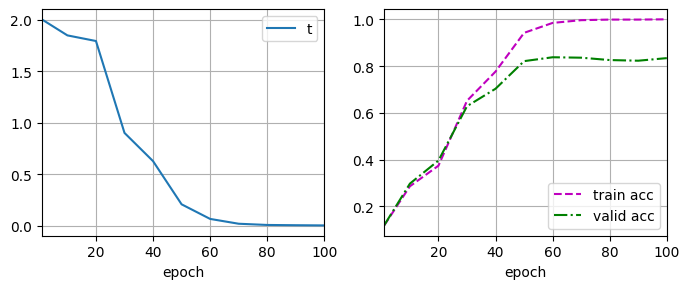

In [41]:
model = GCNModel(num_hiddens=64, num_classes=len(class_map), num_layers=2, dropout=0.25)
model = train_gnn_node_task(model, graph, node_labels, train_nodes, valid_nodes, epochs=100, lr=0.01, verbose=10)

In [42]:
probs = model(graph)
valid_labels = tf.gather(node_labels, valid_nodes).numpy()
valid_probs = tf.gather(probs, valid_nodes).numpy()
valid_acc = tf.keras.metrics.sparse_categorical_accuracy(valid_labels, valid_probs)
print("验证即准确率：%.4f" % valid_acc.numpy().mean())

验证即准确率：0.8321


这是一个多分类问题，我们可以通过混淆矩阵，判断模型预测误差的主要来源
* 可以观察到，模型容易将 `Probabilistic Method` 类别与 `Neural Networks` 混淆

accuracy: 0.8321


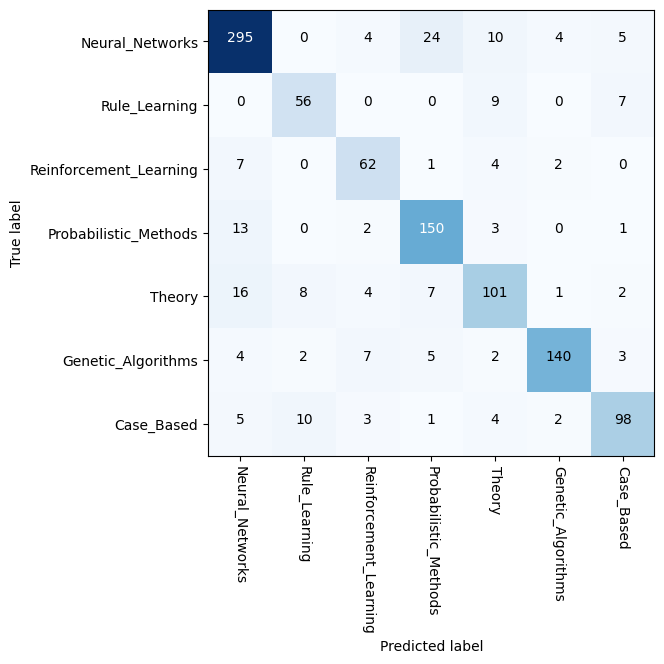

In [43]:
labels = [label_name for label_name,label_idx in class_map.items()]
utils.plot_confusion_matrix(valid_labels, valid_probs.argmax(axis=-1), labels, xrot=-90, figsize=(5, 5))

----

### **练习**

1. 我们继续深入讨论和补充几个 `Cora` 数据集节点分类的实验
   1. 在利用函数 `load_cora_nodetask_data()` 创建和导入 `Cora` 数据集时，**尝试将数据集设置为有向图**，用相同的参数创建 `GCN` 模型进行实验，汇报此事模型在验证集上的准确率
   2. 用相同的参数创建 `GCN` 模型，但**设置 `num_layers = 0` 进行实验**，汇报此事模型在验证集上的准确率，此时模型计算结构退化为什么形式？这还是一个 GNN 吗？模型计算中有利用到图结构信息吗？
   3. 根据以上两个实验，对比**课件中的实现（无向图 + `num_layers = 2`）**，我们能得出哪些结论？

2. 在课件中 `Cora` 节点分类的实验中，我们可以**观察到模型在训练数据集上的正确率达到了 100%**，根据训练中损失和正确率随迭代次数的变化，思考：
   1. 这说明模型出现了过拟合吗？为什么？
   2. 尝试解释在该任务上，模型在训练集上达到 100% 正确率可能的原因，以及为什么在测试集上达不到接近 100%

3. 将 `GNN` 层从 `GCN` 更换为 `GAT` 以搭建基于注意力机制的 GNN 模型 `GATModel`，重新进行实验
   1. 尝试不同的超参数 `num_hiddens`，`num_heads` 和 `num_layers`，一组比较合适的超参数配置方案是什么？
   2. 选择你认为合适的一组超参数训练模型，绘制模型每一层 `GATLayer` 在前 50 个节点上计算时的注意力权重，权重的分布有什么特点？

4. 简单说明，`GCN` 在从邻居节点汇聚特征做信息传递时，节点特征的更新公式可以用下面的矩阵乘法表示：
    $$
    \mathbf{H}^{(l+1)} = f\left( \mathbf{D}^{-1}\cdot \mathbf{A}\cdot  \mathbf{H}^{(l)}\cdot \mathbf{W} +  \mathbf{H}^{(l)}\cdot \mathbf{B} \right)
    $$
    其中：
    * $\mathbf{H}^{(l)}\in\mathbb{R}^{n\times h_l}$ 是第 $l$ 层的节点特征矩阵，$n$ 表示节点数量
    * $\mathbf{W}\in\mathbb{R}^{h_l\times h_{l+1}}, \mathbf{B}\in\mathbb{R}^{h_l\times h_{l+1}}$ 是全连接层的投影矩阵
    * $\mathbf{A}\in\mathbb{R}^{n\times n}$ 是图 $G$ 的 **0-1 邻接矩阵**，$\mathbf{D}\in\mathbb{R}^{n\times n}$ 是其**对角度矩阵**
    * $f$ 是一个逐元素的非线性变换，作为激活函数

----